In [1]:
# General Libraries
import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# NLP
import nltk
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer


# ML/DL
import tensorflow as tf
import pickle

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, BatchNormalization, SpatialDropout1D, GRU, GlobalMaxPool1D, Bidirectional
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import utils
from keras import regularizers
from keras.models import load_model
from keras.initializers import Constant
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
df=pd.read_csv("california_restaurants.csv")

In [3]:
df.head(1)

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date
0,2456,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101,34.414445,-119.690672,4.0,389,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': ""...",Restaurants,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '...",bFPdtzu11Oi0f92EAcjqmg,5,What a great addition to the Funk Zone! Grab ...,2016-10-13 22:50:47


<AxesSubplot:>

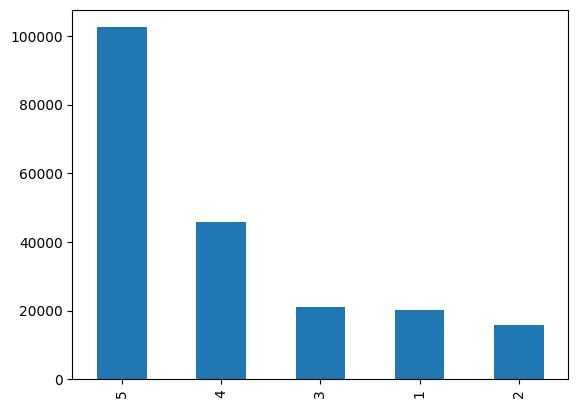

In [4]:
df=df[["text","review_stars"]]
df.review_stars.value_counts().plot(kind="bar")

In [5]:
df_test=df

In [6]:
to_remove = np.random.choice(df_test[df_test['review_stars']==5].index,size=80000,replace=False)
df_testv1=df_test.drop(to_remove)

In [7]:
df_testv1.review_stars.value_counts()

4    45823
5    22470
3    21149
1    20272
2    15750
Name: review_stars, dtype: int64

In [8]:
to_remove = np.random.choice(df_testv1[df_testv1['review_stars']==4].index,size=24000,replace=False)
df_testv1=df_testv1.drop(to_remove)

<AxesSubplot:>

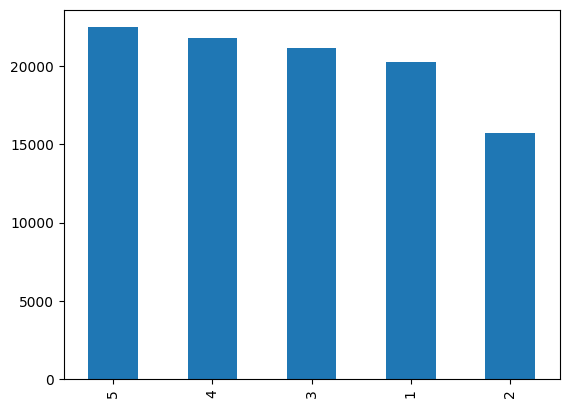

In [9]:
df_testv1.review_stars.value_counts().plot(kind="bar")

In [10]:
df_testv1.to_csv("manual_sample.csv")

#### manual sampling has been done to have an almost balanced dataset

In [21]:
X = df_testv1['text'].fillna('').values
y = df_testv1['review_stars']

In [24]:
X.shape

(101464,)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [23]:
%%time
max_words = 3000
tokenizer = text.Tokenizer(num_words=max_words, char_level=False)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (71024, 3000)
X_test shape: (30440, 3000)
y_train shape: (71024, 5)
y_test shape: (30440, 5)
Wall time: 9.53 s


In [10]:

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [13]:
from keras.losses import mean_absolute_error,binary_crossentropy, categorical_crossentropy

def my_custom_loss(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    crossentropy = categorical_crossentropy(y_true, y_pred)
    return mae + crossentropy

In [36]:
batch_size = 256
epochs = 10


optimizer = keras.optimizers.Adam(learning_rate=.0007, beta_1=0.9, beta_2=0.95, amsgrad=False)

baseline = Sequential()
baseline.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
baseline.add(Dropout(0.3))
baseline.add(Dense(5))
baseline.add(Activation('softmax'))

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = baseline.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
222/222 [==============================] - 2s 5ms/step - loss: 1.7011 - accuracy: 0.5391 - mean_absolute_error: 0.2127 - val_loss: 1.5842 - val_accuracy: 0.5932 - val_mean_absolute_error: 0.2331
Epoch 2/10
222/222 [==============================] - 1s 4ms/step - loss: 1.3160 - accuracy: 0.6666 - mean_absolute_error: 0.1738 - val_loss: 1.4579 - val_accuracy: 0.5954 - val_mean_absolute_error: 0.1972
Epoch 3/10
222/222 [==============================] - 1s 4ms/step - loss: 1.1408 - accuracy: 0.7297 - mean_absolute_error: 0.1526 - val_loss: 1.4894 - val_accuracy: 0.5902 - val_mean_absolute_error: 0.1898
Epoch 4/10
222/222 [==============================] - 1s 4ms/step - loss: 1.0045 - accuracy: 0.7794 - mean_absolute_error: 0.1322 - val_loss: 1.5615 - val_accuracy: 0.5753 - val_mean_absolute_error: 0.1921
Epoch 5/10
222/222 [==============================] - 1s 4ms/step - loss: 0.8942 - accuracy: 0.8205 - mean_absolute_error: 0.1140 - val_loss: 1.6022 - val_accuracy: 0.5747 - va

In [37]:
score = baseline.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1], "Test MAE:", score[2])

119/119 [==============================] - 0s 3ms/step - loss: 1.9249 - accuracy: 0.5649 - mean_absolute_error: 0.1859
Test accuracy: 0.5649474263191223 Test MAE: 0.1858862340450287


In [40]:
y_pred = baseline.predict(X_test)

cols = [1, 2, 3, 4, 5]

# Creating predictions table
baseline_ps = pd.DataFrame(data=y_pred, columns=cols)
y_pred_true = baseline_ps.idxmax(axis=1)

# Creating truth
baseline_truth = pd.DataFrame(data=y_test, columns=cols)
y_test_true = baseline_truth.idxmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_pred_true, y_test_true)
pd.DataFrame(cm, index=cols, columns=cols)

952/952 [==============================] - 1s 1ms/step


,1,2,3,4,5
1,4227,1223,488,109,71
2,1401,2008,1367,244,71
3,375,1205,3104,1205,267
4,73,173,1288,3579,2043
5,37,40,154,1409,4279


In [41]:
print(classification_report(y_pred_true, y_test_true))

              precision    recall  f1-score   support

           1       0.69      0.69      0.69      6118
           2       0.43      0.39      0.41      5091
           3       0.48      0.50      0.49      6156
           4       0.55      0.50      0.52      7156
           5       0.64      0.72      0.68      5919

    accuracy                           0.56     30440
   macro avg       0.56      0.56      0.56     30440
weighted avg       0.56      0.56      0.56     30440



In [42]:
def test_model(params):
    print(params)
    batch_size, epochs, learning_rate = params
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.95, amsgrad=False)

    baseline = Sequential()
    baseline.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              activity_regularizer=regularizers.l2(1e-5)))
    baseline.add(BatchNormalization())
    baseline.add(Activation('relu'))
    baseline.add(Dropout(0.3))
    baseline.add(Dense(5))
    baseline.add(Activation('softmax'))
    
    baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])
    
    history = baseline.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.2)
    
    score = baseline.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print(score[1:])
    
    return score[1:]

In [45]:
!nvidia-smi

Wed Nov 30 06:23:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.47       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8     9W / 200W |   7567MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [48]:
!nvidia-smi

Wed Nov 30 06:25:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.47       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8    11W / 200W |   1654MiB /  8192MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
%%time
X = df_testv1['text'].fillna('').values
y = pd.get_dummies(df_testv1['review_stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
max_words = 5000
maxlen = 500

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# For the LSTM, we are going to pad our sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

(71024,) (71024, 5)
(30440,) (30440, 5)
Wall time: 3.88 s


In [14]:
batch_size = 128
epochs = 8

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

lstm = Sequential()
lstm.add(Embedding(max_words, 128, input_length=maxlen))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4)))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(BatchNormalization())
lstm.add(Dense(50))
lstm.add(Dense(5, activation='sigmoid'))

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,validation_split=0.2)

Epoch 1/8
444/444 [==============================] - 173s 371ms/step - loss: 1.3316 - accuracy: 0.5411 - mean_absolute_error: 0.2568 - val_loss: 1.3669 - val_accuracy: 0.4717 - val_mean_absolute_error: 0.2033
Epoch 2/8
444/444 [==============================] - 164s 369ms/step - loss: 1.0925 - accuracy: 0.6179 - mean_absolute_error: 0.1884 - val_loss: 1.1742 - val_accuracy: 0.5816 - val_mean_absolute_error: 0.1917
Epoch 3/8
444/444 [==============================] - 168s 379ms/step - loss: 1.0159 - accuracy: 0.6529 - mean_absolute_error: 0.1827 - val_loss: 1.1960 - val_accuracy: 0.5887 - val_mean_absolute_error: 0.1828
Epoch 4/8
444/444 [==============================] - 172s 386ms/step - loss: 0.9439 - accuracy: 0.6873 - mean_absolute_error: 0.1759 - val_loss: 1.2019 - val_accuracy: 0.5723 - val_mean_absolute_error: 0.1935
Epoch 5/8
444/444 [==============================] - 192s 432ms/step - loss: 0.8728 - accuracy: 0.7163 - mean_absolute_error: 0.1675 - val_loss: 1.1683 - val_accura

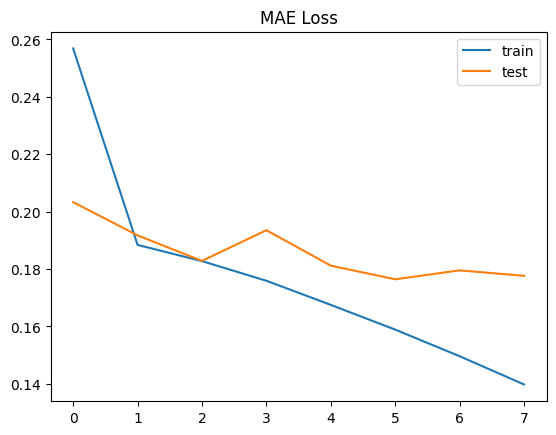

In [18]:
plt.title('MAE Loss')
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='test')
plt.legend()
plt.show()

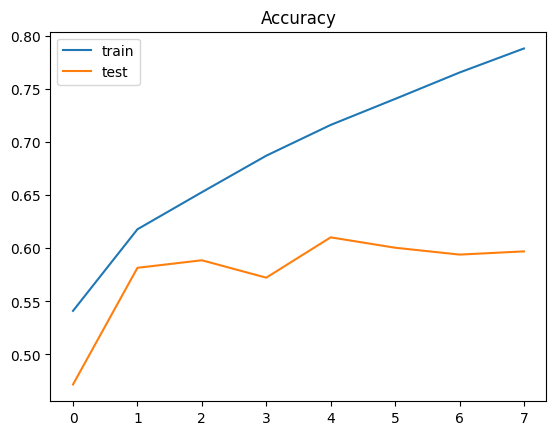

In [19]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [20]:
y_pred = lstm.predict(X_test)
y_pred

cols = [1, 2, 3, 4, 5]

# Creating predictions table
baseline_ps = pd.DataFrame(data=y_pred, columns=cols)
y_pred_true = baseline_ps.idxmax(axis=1)
y_pred_true

# Creating truth
baseline_truth = pd.DataFrame(data=y_test, columns=cols)
y_test_true = baseline_truth.idxmax(axis=1)
y_test_true

# Confusion matrix
cm = confusion_matrix(y_pred_true, y_test_true)


952/952 [==============================] - 60s 62ms/step


,1,2,3,4,5
1,4804,1638,564,144,123
2,885,1863,1118,133,27
3,275,1083,3496,1465,228
4,48,81,857,3398,1889
5,30,29,146,1464,4652


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
print(classification_report(y_true=y_pred_true,y_pred= y_test_true))

              precision    recall  f1-score   support

           1       0.80      0.66      0.72      7273
           2       0.40      0.46      0.43      4026
           3       0.57      0.53      0.55      6547
           4       0.51      0.54      0.53      6273
           5       0.67      0.74      0.70      6321

    accuracy                           0.60     30440
   macro avg       0.59      0.59      0.59     30440
weighted avg       0.61      0.60      0.60     30440



In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

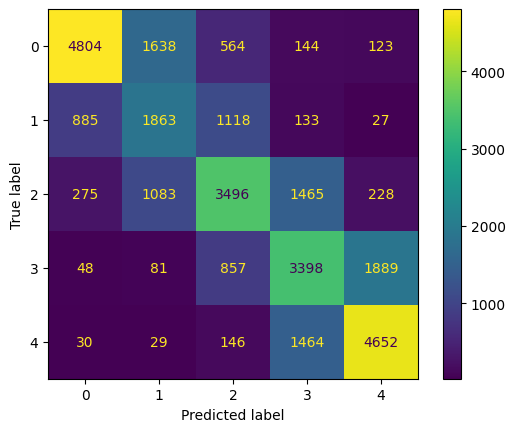

In [23]:
disp.plot()